# Fitting Data - A Guide

In your labs you will be required to fit different models to various kinds of data. The most common model you will use is a straight line, but you could also be required to fit an exponential curve, or a gaussian. 

Thankfully, Python and the various scientific computing packages offered alongside it (Numpy, Scipy, Pandas, etc) offer a multitude of different ways of fitting curves to data. This workbook will cover some of the recommended methods. 

## Least Squares

A fitting algorithm is designed to minimise the sum total of the square of the difference between your fit line and data values, hence the name "least squares". There are numerous algorithms designed to achieve this: common ones include the Gauss-Newton and Levenberg–Marquardt algorithms. In this module, however, you don't need to know how the algorithms work, just how to use them.

First of all, we should generate some fake data for our fitting example.

<ErrorbarContainer object of 3 artists>

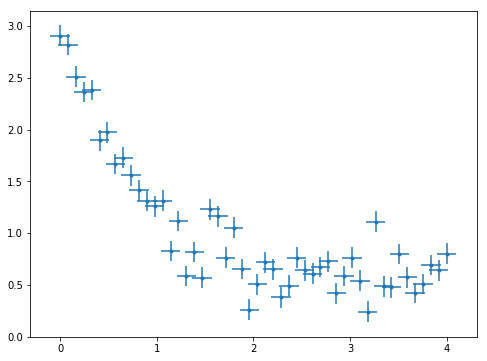

In [8]:
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
import numpy as np

# Generate x data and some constant errors
xdata = np.linspace(0, 4, 50)
xerror = np.ones_like(xdata)*0.1

# Generate y data and some constant errors
y = 2.5 * np.exp(-1.3 * xdata) + 0.5
y_noise = 0.2 * np.random.normal(size=xdata.size)

ydata = y + y_noise
yerror = np.ones_like(ydata)*0.1

# Plot data
fig = plt.figure(figsize = (8, 6))
plt.errorbar(xdata, ydata, yerror, xerror, marker='.', linestyle='', label='data')
plt.show

The data generated is that of a basic, single-term, exponential decay. The uncertainty on each data point is given as a constant 0.1. The next step is to try and do a fit to this using the **least_squares()** function. 

The first thing to do in fitting is define our fit model. This is, of course, an exponential curve with three fit parameters: an amplitude, a decay constant, and a constant addition term at the end. 

$$ f(x) = a e^{-bx} + c $$

We must also define the error function, which is the first (partial) differential of the fit function:

$$ f'(x) = -ab e^{-bx} $$

Both of these functions are detailed below, along with the **calcChiSq()** function, which utlises the first two functions to calculate the $\chi^2$ values for the fit (if you haven't already viewed the $\chi^2$ guide you should do so now).

In [9]:
def fitFunc(p, x):
    '''
    Fit function
    '''
    f = p[0] * np.exp(-p[1] * x) + p[2]
    return f

def fitFuncDiff(p, x):
    '''
    Differential of fit function
    '''
    df = -p[0]*p[1] * np.exp(-p[1] * x)
    return df

def calcChiSq(p, x, y, xerr, yerr):
    '''
    Error function for fit
    '''
    e = (y - fitFunc(p, x))/(np.sqrt(yerr**2 + fitFuncDiff(p, x)**2*xerr**2))
    return e

The standard error on the fit parameters is non-trivial to obtain using the **least_squares()** method. The below function does this for you - all it requires as input is the matrix *output.jac* from your best fit. Don't worry about how this works for now.

In [18]:
def fitStdError(jacMatrix):

    # Compute covariance
    jMat2 = np.dot(jacMatrix.T, jacMatrix)
    detJmat2 = np.linalg.det(jMat2)
    
    # Prepare output
    output = np.zeros(jMat2.shape[0])
    if detJmat2 < 1E-32:
        print("Value of determinat detJmat2",detJmat2)
        print("Matrix singular, error calculation failed.")
        return output
    else:
        covar = np.linalg.inv(jMat2)
        for i in range(len(output)):
            output[i] = np.sqrt(covar[i, i])
            
        return output

The final step is to perform the actual fit. When fitting, to help the algorithm find ideal parameters, you should provide rough initial estimates of the parameters. Usually the fitting algorithm is good at finding the parameters even with terrible initial guesses, but for very complex models with several parameters, good initial guesses are important for the convergence of the fit.

Initial guesses for the fit parameters are entered below, **pInit**. You can also set absolute upper and lower bounds of these estimates, **lBounds** & **uBounds**. The initial parameters and data are provided to the **least_squares()** function and the fit is performed. 

The code then extracts the fitted parameters **A, b, c** and their uncertainties. These are then printed to the screen. Finally, the $\chi^2/\mathrm{NDF}$ is calculated, and the fit is plotted alongside the original data. 

Fitted parameters a: 2.73, b: 1.47, c: 0.56
Parameter errors: a: 0.21, b: 0.13, c: 0.03
ChiSq = 1.61e+02, ChiSq/NDF =  3.43.


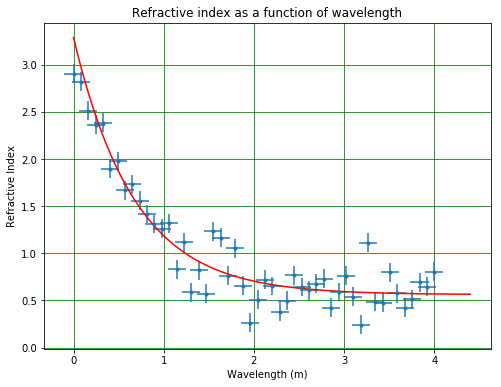

In [27]:
# Set initial values of fit parameters
#          0         1        2         
#          A         b         c  
pInit =   [1,        1,       -1]
lBounds = [-10,      -10,     -10]
uBounds = [10,       10,       10]
nPoints = len(xdata)
nPars = 3

# Run fit
output = least_squares(calcChiSq, pInit, args = (xdata, ydata, xerror, yerror),
                    bounds = (lBounds, uBounds))



# Get least_squares output, stored in array output.x[]
A = output.x[0]
b = output.x[1]
c = output.x[2]

# Get errors from our fits using fitStdError(), defined above
pErrors = fitStdError(output.jac)
d_A = pErrors[0]
d_b = pErrors[1]
d_c = pErrors[2]

# Output fit parameters
print("Fitted parameters a: {0:.2f}, b: {1:.2f}, c: {2:.2f}".format(A, b, c))
print("Parameter errors: a: {0:.2f}, b: {1:.2f}, c: {2:.2f}".format(d_A, d_b, d_c))



# Calculate chis**2 per point, summed chi**2 and chi**2/NDF
chiarr = calcChiSq(output.x, xdata, ydata, xerror, yerror)**2
chisq = np.sum(chiarr)
NDF = nPoints - nPars
chisqndf = chisq/NDF
print("ChiSq = {:5.2e}, ChiSq/NDF = {:5.2f}.".format(chisq, chisqndf))

# Calculate fitted y-values using our fit parameters and the original fit function
xPlot = np.linspace(0.9*np.min(xdata), 1.1*np.max(xdata), 100)
fitData = fitFunc(output.x, xPlot)

# Make the plot of the data and the fit
fig = plt.figure(figsize = (8, 6))
plt.title('Refractive index as a function of wavelength')
plt.xlabel('Wavelength (m)')
plt.ylabel('Refractive Index')
plt.grid(color = 'g')
plt.errorbar(xdata, ydata, yerror, xerror, marker='.', linestyle='', label='data')
plt.plot(xPlot, fitData, color = 'r')
plt.show()

It can be seen that even with the crude initial estimates and the huge boundary conditions, the fit algorithm has converged and produced a sensible looking fit with a good $\chi^2$ value.

## Orthogonal Distance Regression (ODR)

There exists another function within the *SciPy* package called Orthogonal Distance Regression (ODR). This does the same thing as above, with less lines of code. If you're feeling confident in your coding skills and want to switch up from what you already know, try this function out!

In [24]:
import scipy.odr as odr

expModel = odr.Model(fitFunc)  # Generate odr model using the above exponential function

fitData = odr.Data(xdata, ydata, xerror, yerror) # Put data into our ODR Data object for fitting

odrObject_1 = odr.ODR(fitData, expModel, beta0=[1.,1.,1.]) # Make ODR fit object with our data and initial estimates (beta0)

odrFit_1 = odrObject_1.run() # Perform the fit, odrFit_n will contain all the information about our fit.
odrFit_1.pprint() # Print out statistics

Beta: [2.71100983 1.48292713 0.56146549]
Beta Std Error: [0.36465967 0.22990316 0.049091  ]
Beta Covariance: [[38.76808541 17.9885804   1.39075575]
 [17.9885804  15.40950858  2.29920692]
 [ 1.39075575  2.29920692  0.70259119]]
Residual Variance: 0.0034300551786049407
Inverse Condition #: 0.06887684967199027
Reason(s) for Halting:
  Sum of squares convergence


The use of ODR is very simple: you just need to model your function using **odr.Model()**; pass your data to the model using **odr.Data()**; put both model and data into an ODR object using **odr.ODR()**; then run the fit on your ODR object using the **.run()** method. 

The resultant fit is displayed in the plot below. The fitted output parameters are stored in the array **beta[]**, and the standard error on these is stored in the array **sd_beta[]**. Accessing these is simple, as detailed below.

Finally, you can use the fitted parameters and your data with the **fitError()** function to calculate the $\chi^2 /\mathrm{NDF}$ value for the fit.

Fitted parameters a: 2.71, b: 1.48, c: 0.56
Parameter stderr: a: 0.36, b: 0.23, c: 0.05
ChiSq/NDF: 3.4292


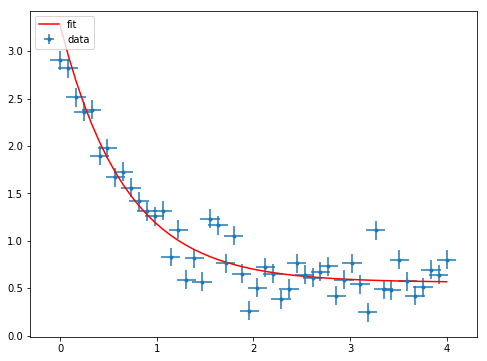

In [31]:
# Plot figure and fit
fig = plt.figure(figsize = (8, 6))
plt.errorbar(xdata, ydata, yerror, xerror, marker='.', linestyle='', label='data')
plt.plot(xdata, fitFunc(odrFit_1.beta, xdata), color = 'r', label='fit')
plt.legend(loc = 2)

# Output fit parameters
print("Fitted parameters a: {0:.2f}, b: {1:.2f}, c: {2:.2f}".format(odrFit_1.beta[0], odrFit_1.beta[1], odrFit_1.beta[2]))
print("Parameter stderr: a: {0:.2f}, b: {1:.2f}, c: {2:.2f}".format(odrFit_1.sd_beta[0], odrFit_1.sd_beta[1], odrFit_1.sd_beta[2]))

# Calculate chisq/ndf
chiarr = calcChiSq(odrFit_1.beta, xdata, ydata, xerror, yerror)**2
chisqndf = np.sum(chiarr)/( len(xdata) - 3) #Number of data - number of parameters

print("ChiSq/NDF: {0:.4f}".format(chisqndf))

By default, ODR uses numerical differentiation to estimate the error function for the fit model. This is a disadvantage compared to the **least_squares()** method, but should only present an issue for fit models that do not vary smoothly with x. 